In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, roc_curve,confusion_matrix
from sklearn.neural_network import MLPClassifier  # Importing MLPClassifier
import time

In [21]:
# function to read different file formats
def dataset_arrange(data_file):
    if data_file[-3:] == 'mat':
        load_file = scipy.io.loadmat(data_file)
        data_df = pd.DataFrame(load_file['meas'])
        sp = []
        for i in range(150):
            sp.append(load_file['species'][i][0][0])
        species_df = pd.DataFrame({"species": sp})
        total_frame = [species_df,data_df]
        total_df = pd.concat(total_frame,axis = 1,join ="inner")
    elif data_file[-3:] == 'csv':
        load_file = pd.read_csv(data_file)
        total_df = load_file 
    elif data_file[-3:] == 'xlsx':
        load_file = pd.read_excel(data_file)
        total_df = load_file
    return total_df

In [22]:
total_df = dataset_arrange('fisheriris.mat')
total_df

,species,0,1,2,3
0,setosa,5.1,3.5,1.4,0.2
1,setosa,4.9,3.0,1.4,0.2
2,setosa,4.7,3.2,1.3,0.2
3,setosa,4.6,3.1,1.5,0.2
4,setosa,5.0,3.6,1.4,0.2
...,...,...,...,...,...
145,virginica,6.7,3.0,5.2,2.3
146,virginica,6.3,2.5,5.0,1.9
147,virginica,6.5,3.0,5.2,2.0
148,virginica,6.2,3.4,5.4,2.3


In [23]:
pd.Series(scipy.io.loadmat('fisheriris.mat'))

__header__     b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Crea...
__version__                                                  1.0
__globals__                                                   []
l              [[[[[array(['setosa'], dtype='<U6')]\n [array(...
meas           [[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2], [...
species        [[[setosa]], [[setosa]], [[setosa]], [[setosa]...
dtype: object

In [24]:
# function to split and shuffle dataset 
def BT20ECE097_split(total_df,ratio):
    output = []
    total_df = total_df.sample(frac = 1,random_state = 28) 
    X = np.array(total_df.iloc[:,1:])
    Y = np.array(total_df['species'])
    split_1 = math.floor(ratio * X.shape[0])
    split_2 = math.ceil(((1-ratio)/2) * X.shape[0])
    X_train = X[:split_1]
    Y_train = Y[:split_1]
    X_test = X[split_1:split_1+split_2]
    Y_test = Y[split_1:split_1+split_2]
    X_val = X[split_1+split_2:]
    Y_val = Y[split_1+split_2:]
    output = [X_train,Y_train,X_test,Y_test,X_val,Y_val]
    return output

In [25]:
list_data = BT20ECE097_split(total_df,0.7)

In [26]:
svm_linear = SVC(kernel='linear',decision_function_shape='ovr')
svm_poly = SVC(kernel='poly',decision_function_shape='ovr')
svm_rbf = SVC(kernel='rbf',decision_function_shape='ovr')
svm_linear.fit(list_data[0],list_data[1])
svm_poly.fit(list_data[0],list_data[1])
svm_rbf.fit(list_data[0],list_data[1])

SVC()

In [27]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=np.unique(y))
    return accuracy, report

In [28]:
def plot_roc_multi_class(y_true, y_score, title):
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(fpr[i], tpr[i])

    # Plotting all ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [47]:
# Performing grid search for linear kernel
param_grid_linear = {'C': [0.1, 1, 10, 100]}
grid_linear = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=5)
s_t = time.time()
grid_linear.fit(list_data[0], list_data[1])
svm_training_time = time.time() - s_t
print(f"SVM Training Time(Linear Kernel): {svm_training_time:.4f} seconds")
best_linear_model = grid_linear.best_estimator_

# Performing grid search for polynomial kernel
param_grid_poly = {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4]}
grid_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly, cv=5)
s_t = time.time()
grid_poly.fit(list_data[0], list_data[1])
svm_training_time = time.time() - s_t
print(f"SVM Training Time(Polynomial Kernel): {svm_training_time:.4f} seconds")
best_poly_model = grid_poly.best_estimator_

# Performing grid search for RBF kernel
param_grid_rbf = {'C': [0.1, 1, 10, 100], 'gamma': [0.01,0.1, 1, 10]}
grid_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid_rbf, cv=5)
s_t = time.time()
grid_rbf.fit(list_data[0], list_data[1])
svm_training_time = time.time() - s_t
print(f"SVM Training Time(RBF Kernel): {svm_training_time:.4f} seconds")
best_rbf_model = grid_rbf.best_estimator_


SVM Training Time(Linear Kernel): 0.0321 seconds
SVM Training Time(Polynomial Kernel): 0.0675 seconds
SVM Training Time(RBF Kernel): 0.0966 seconds


In [30]:
# Evaluating models
def evaluate_models(model, X_train, y_train, X_test, y_test, kernel_name):
    print(f"Evaluation for {kernel_name} Kernel:")
    
    accuracy_train, report_train = evaluate_model(model, X_train, y_train)
    print("Accuracy (Train):", accuracy_train)
    print("Classification Report (Train):\n", report_train)
    
    accuracy_test, report_test = evaluate_model(model, X_test, y_test)
    print("Accuracy (Test):", accuracy_test)
    print("Classification Report (Test):\n", report_test)
    
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_score = model.decision_function(X_test)

    plot_roc_multi_class(y_test_bin, y_score , title=f"ROC Curve - {kernel_name} Kernel")


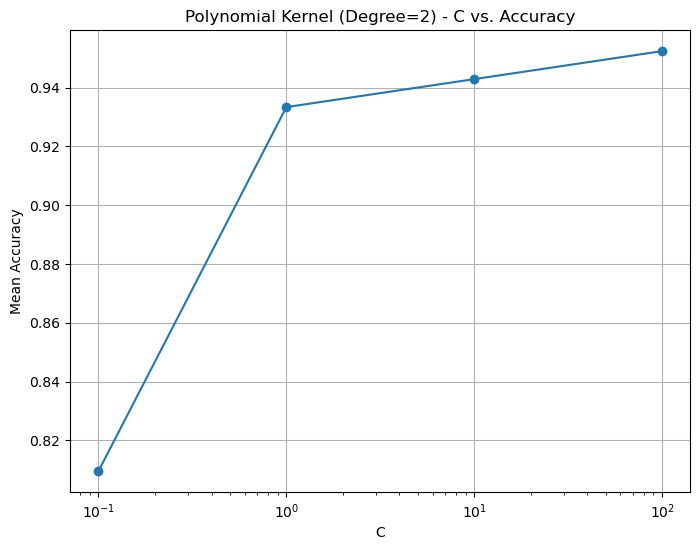

Best Hyperparameters for Polynomial Kernel (Degree=2): C=100.0
Best Accuracy for Polynomial Kernel (Degree=2): 0.9523809523809523




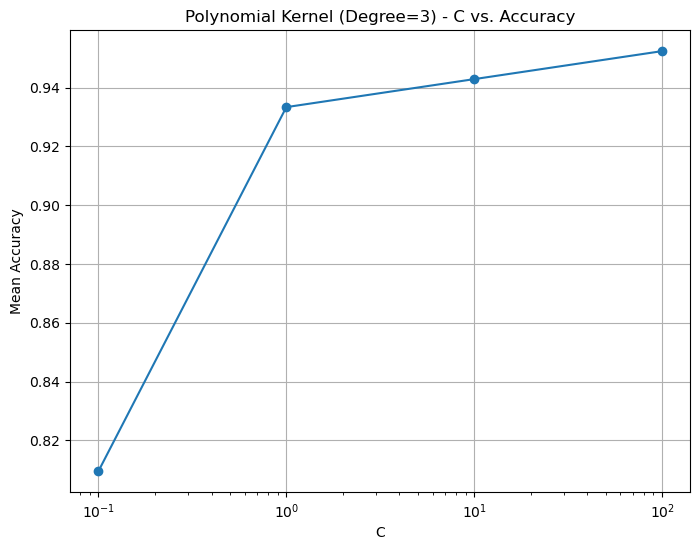

Best Hyperparameters for Polynomial Kernel (Degree=3): C=100.0
Best Accuracy for Polynomial Kernel (Degree=3): 0.9523809523809523




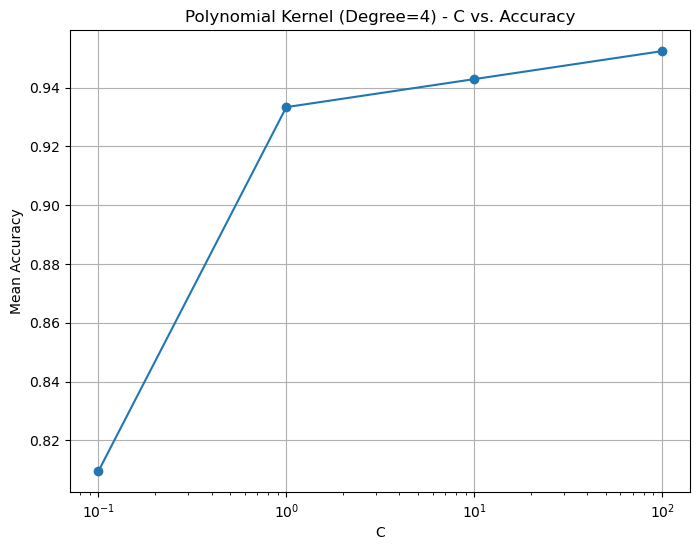

Best Hyperparameters for Polynomial Kernel (Degree=4): C=100.0
Best Accuracy for Polynomial Kernel (Degree=4): 0.9523809523809523


Best Hyperparameters for Polynomial Kernel:
Degree=2, C=100.0, Accuracy=0.9523809523809523
Degree=3, C=100.0, Accuracy=0.9523809523809523
Degree=4, C=100.0, Accuracy=0.9523809523809523


In [31]:

# Defining a range of hyperparameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100],
              'degree': [2, 3, 4],  # Different values of degree
              'kernel': ['poly']}  # Keeping the kernel constant as Polynomial

# Initialize an SVM classifier
svm = SVC()

# Creating a plot for each degree value and printing best hyperparameters
best_hyperparameters = {}

for degree in param_grid['degree']:
    plt.figure(figsize=(8, 6))
    
    # Filter the data for the current degree value
    degree_mask = param_grid['degree'] == degree
    param_C = np.array(param_grid['C'])
    
    # Performing grid search with cross-validation
    grid_search = GridSearchCV(svm, {'C': param_C, 'degree': [degree]}, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(list_data[0], list_data[1])
    
    # Extracting the results of the grid search
    mean_accuracy = grid_search.cv_results_['mean_test_score']
    
    # Plotting C vs. accuracy for the current degree value
    plt.plot(param_C, mean_accuracy, marker='o')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Mean Accuracy')
    plt.title(f'Polynomial Kernel (Degree={degree}) - C vs. Accuracy')
    plt.grid(True)
    
    plt.show()

    # Printing the best hyperparameters and corresponding accuracy for the current degree value
    best_C = grid_search.best_params_['C']
    best_accuracy = grid_search.best_score_
    best_hyperparameters[degree] = {'C': best_C, 'Accuracy': best_accuracy}
    print(f"Best Hyperparameters for Polynomial Kernel (Degree={degree}): C={best_C}")
    print(f"Best Accuracy for Polynomial Kernel (Degree={degree}): {best_accuracy}")
    print("\n")

# Printing the best hyperparameters for all degree values
print("Best Hyperparameters for Polynomial Kernel:")
for degree, params in best_hyperparameters.items():
    print(f"Degree={degree}, C={params['C']}, Accuracy={params['Accuracy']}")


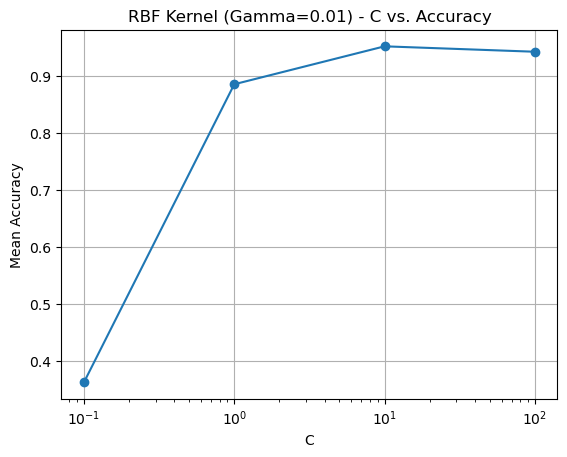

Best Hyperparameters for RBF Kernel (Gamma=0.01): C=10.0
Best Accuracy for RBF Kernel (Gamma=0.01): 0.9523809523809523




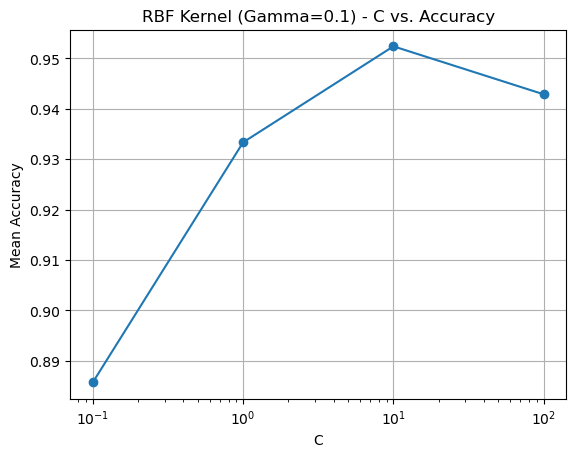

Best Hyperparameters for RBF Kernel (Gamma=0.1): C=10.0
Best Accuracy for RBF Kernel (Gamma=0.1): 0.9523809523809523




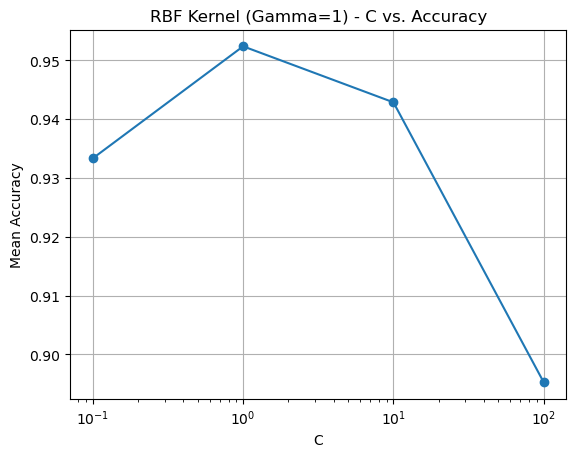

Best Hyperparameters for RBF Kernel (Gamma=1): C=1.0
Best Accuracy for RBF Kernel (Gamma=1): 0.9523809523809523




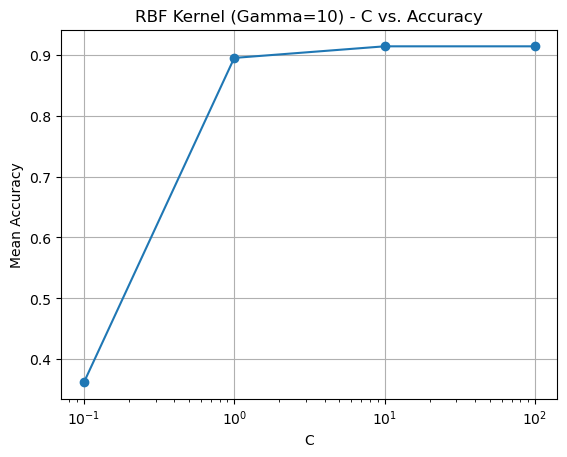

Best Hyperparameters for RBF Kernel (Gamma=10): C=10.0
Best Accuracy for RBF Kernel (Gamma=10): 0.9142857142857143


Best Hyperparameters for RBF Kernel:
Gamma=0.01, C=10.0, Accuracy=0.9523809523809523
Gamma=0.1, C=10.0, Accuracy=0.9523809523809523
Gamma=1, C=1.0, Accuracy=0.9523809523809523
Gamma=10, C=10.0, Accuracy=0.9142857142857143


In [32]:

# Defining a range of hyperparameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10],  # Different values of gamma
              'kernel': ['rbf']}  # Keeping the kernel constant as RBF

# Initializing an SVM classifier
svm = SVC()

# Creating a plot for each gamma value and print best hyperparameters
best_hyperparameters = {}

for gamma in param_grid['gamma']:
    # Filtering the data for the current gamma value
    gamma_mask = param_grid['gamma'] == gamma
    param_C = np.array(param_grid['C'])
    
    # Performing grid search with cross-validation
    grid_search = GridSearchCV(svm, {'C': param_C, 'gamma': [gamma]}, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(list_data[0], list_data[1])
    
    # Extracting the results of the grid search
    mean_accuracy = grid_search.cv_results_['mean_test_score']
    
    # Plotting C vs. accuracy for the current gamma value
    plt.plot(param_C, mean_accuracy, marker='o')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Mean Accuracy')
    plt.title(f'RBF Kernel (Gamma={gamma}) - C vs. Accuracy')
    plt.grid(True)
    plt.show()

    # Printing the best hyperparameters and corresponding accuracy for the current gamma value
    best_C = grid_search.best_params_['C']
    best_accuracy = grid_search.best_score_
    best_hyperparameters[gamma] = {'C': best_C, 'Accuracy': best_accuracy}
    print(f"Best Hyperparameters for RBF Kernel (Gamma={gamma}): C={best_C}")
    print(f"Best Accuracy for RBF Kernel (Gamma={gamma}): {best_accuracy}")
    print("\n")

# Printing the best hyperparameters for all gamma values
print("Best Hyperparameters for RBF Kernel:")
for gamma, params in best_hyperparameters.items():
    print(f"Gamma={gamma}, C={params['C']}, Accuracy={params['Accuracy']}")


Evaluation for Linear Kernel:
Accuracy (Train): 0.9809523809523809
Classification Report (Train):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       1.00      0.95      0.97        38
   virginica       0.95      1.00      0.97        35

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

Accuracy (Test): 1.0
Classification Report (Test):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         6
  versicolor       1.00      1.00      1.00         8
   virginica       1.00      1.00      1.00         9

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



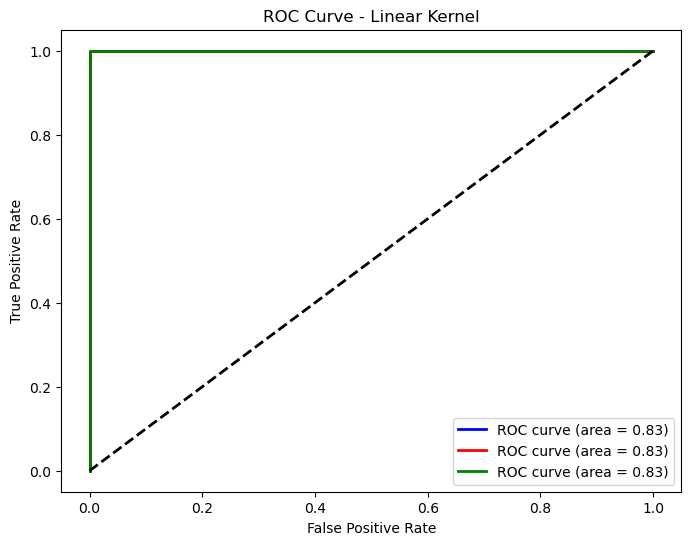

Evaluation for Polynomial Kernel:
Accuracy (Train): 0.9809523809523809
Classification Report (Train):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       0.97      0.97      0.97        38
   virginica       0.97      0.97      0.97        35

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

Accuracy (Test): 1.0
Classification Report (Test):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         6
  versicolor       1.00      1.00      1.00         8
   virginica       1.00      1.00      1.00         9

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



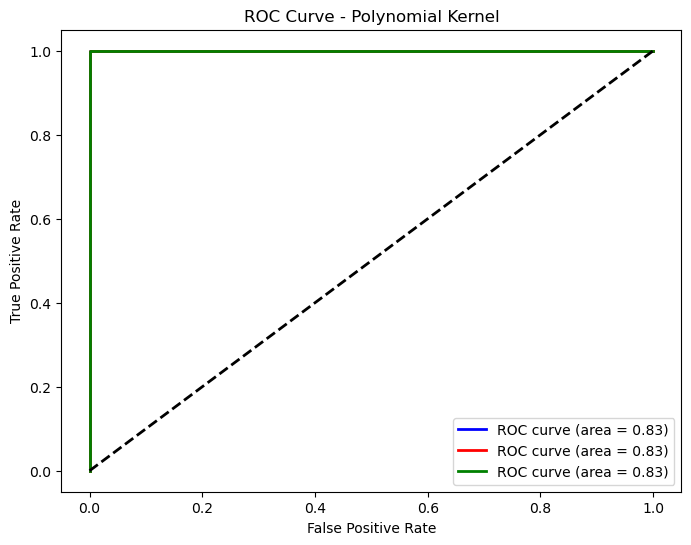

Evaluation for RBF Kernel:
Accuracy (Train): 0.9809523809523809
Classification Report (Train):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        32
  versicolor       1.00      0.95      0.97        38
   virginica       0.95      1.00      0.97        35

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105

Accuracy (Test): 1.0
Classification Report (Test):
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         6
  versicolor       1.00      1.00      1.00         8
   virginica       1.00      1.00      1.00         9

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



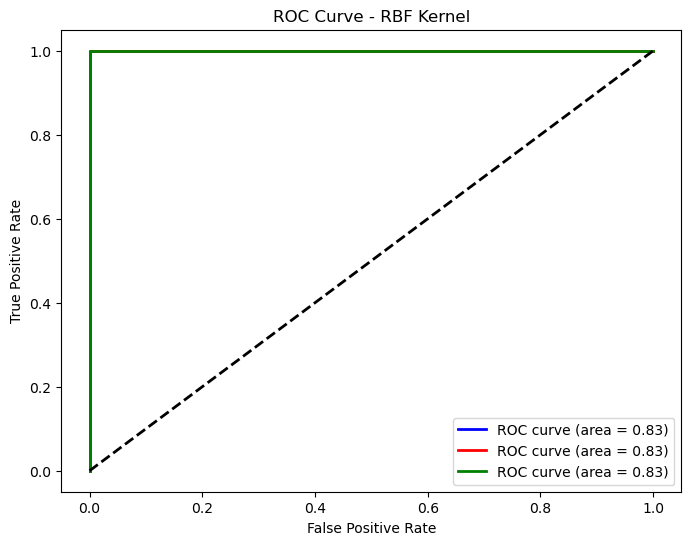

In [33]:
# Evaluating Linear Kernel
evaluate_models(best_linear_model, list_data[0], list_data[1], list_data[2], list_data[3], "Linear")

# Evaluating Polynomial Kernel
evaluate_models(best_poly_model, list_data[0], list_data[1], list_data[2], list_data[3], "Polynomial")

# Evaluating RBF Kernel
evaluate_models(best_rbf_model, list_data[0], list_data[1], list_data[2], list_data[3], "RBF")

In [34]:
# Defining a range of hyperparameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf']}

# Initializing an SVM classifier
svm = SVC()

# Creating dictionaries to store results for each kernel
sensitivity_scores = {}
specificity_scores = {}

# Looping through each kernel
for kernel in param_grid['kernel']:
    # Performing grid search with cross-validation
    grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(list_data[0], list_data[1].ravel())  # Using .ravel() to convert y_train to 1D array
    
    # Getting the best model
    best_model = grid_search.best_estimator_
    
    # Predicting on the validation set
    y_pred = best_model.predict(list_data[4])
    
    # Calculating confusion matrix
    cm = confusion_matrix(list_data[5], y_pred)
    
    # Calculating sensitivity and specificity for each class
    sensitivity = []
    specificity = []
    for i in range(len(np.unique(list_data[5]))):
        true_positives = cm[i, i]
        false_positives = cm[:, i].sum() - true_positives
        false_negatives = cm[i, :].sum() - true_positives
        true_negatives = cm.sum() - (true_positives + false_positives + false_negatives)
        
        sensitivity.append(true_positives / (true_positives + false_negatives))
        specificity.append(true_negatives / (true_negatives + false_positives))
    
    # Storing sensitivity and specificity scores for the current kernel
    sensitivity_scores[kernel] = sensitivity
    specificity_scores[kernel] = specificity

# Printing the sensitivity and specificity scores for each class and kernel
for kernel, sensitivity in sensitivity_scores.items():
    print(f"Sensitivity Scores for {kernel} Kernel:")
    for i, score in enumerate(sensitivity):
        print(f"Class {i}: {score:.4f}")
    print()

for kernel, specificity in specificity_scores.items():
    print(f"Specificity Scores for {kernel} Kernel:")
    for i, score in enumerate(specificity):
        print(f"Class {i}: {score:.4f}")
    print()


Sensitivity Scores for linear Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000

Sensitivity Scores for poly Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000

Sensitivity Scores for rbf Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000

Specificity Scores for linear Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000

Specificity Scores for poly Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000

Specificity Scores for rbf Kernel:
Class 0: 1.0000
Class 1: 1.0000
Class 2: 1.0000



In [38]:
# Defining and training an ANN model using MLPClassifier
ann_model = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=50)
start_time = time.time()
ann_model.fit(list_data[0], list_data[1].ravel())
ann_training_time = time.time() - start_time

ann_accuracy = ann_model.score(list_data[2], list_data[3])

print(f"ANN Accuracy: {ann_accuracy:.4f}")
print(f"ANN Training Time: {ann_training_time:.4f} seconds")

ANN Accuracy: 1.0000
ANN Training Time: 0.0281 seconds


C:\Users\somur\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
